# Experiments in Model Tuning

1. Verify the number of clusters that we are selecting.

In [1]:
# standard imports
import numpy as np
import os

# plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# data management
import pandas as pd

# import optimizer
from scipy.optimize import curve_fit

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

# standard scrapers
import hittingpredictor as hp
import pitchingpredictor as pp




In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['ytick.major.size'] = 0
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt

fpath = os.path.join(rcParams["datapath"], '/Users/mpetersen/Downloads/Roboto_Condensed/RobotoCondensed-Regular.ttf')
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['font.weight'] = 'medium'









## Part 1: Hitting

### Petersen method

Generate clusters, then look at associations and where the creation of arbitrary clusters stops making sense.

In [3]:

# which years are we interested in querying?
years = range(2019-3, 2019+1)


year_dfs = []

for year in years:
    print(year)

    df = hp.scrape_year(year=year,cat='bat',verbose=0)
    year_dfs.append(df)

# concatenate results from all years
all_year_data = year_dfs[0]
for year in year_dfs[1:]:
    all_year_data = pd.concat([all_year_data, year])
    




2016
2017
2018
2019


Text(0, 0.5, 'k Level')

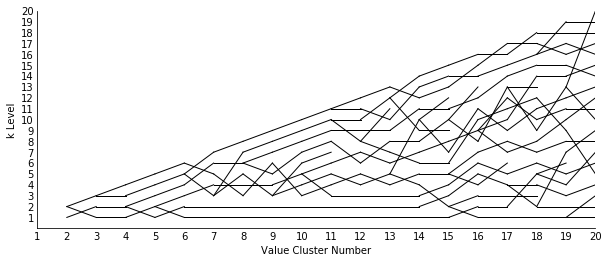

In [4]:

plt.figure(figsize=(10,4))

for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = hp.compute_cluster(all_year_data,years,nclusters1,min_pas=150,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:6]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = hp.compute_cluster(all_year_data,years,nclusters2,min_pas=150,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:6]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        plt.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='black',lw=1.)
     

plt.axis([1,20,0,20])

plt.xticks(np.arange(1,21,1))
plt.yticks(np.arange(1,21,1))
plt.xlabel('Value Cluster Number')
plt.ylabel('k Level')





### Rentz Method

Fit an exponential decline to the total distance metric.

Text(21.25, 0.5, 'Distance')

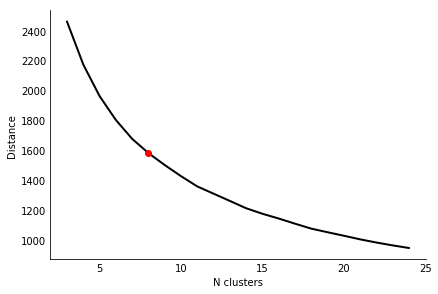

In [5]:

min_clusters = 3
nclusters = np.arange(min_clusters,25,1)#range(2,15)
distances = np.zeros(len(nclusters))

for indx,ccen in enumerate(nclusters):

    year_df,df,stereotype_df,hitter_cluster_centroid_df,transform = hp.compute_cluster(all_year_data,years,ccen,min_pas=150,verbose=0)

    
    for p in transform:
        # why is this the minimum value?
        distances[indx] += np.sqrt(np.sum(p))
        #distances[indx] += np.sum(np.sqrt(p))

    distances[indx] /= float(ccen)
    #print(ccen,distances[indx])
     
        
# after doing the centering, compute the exponential decline
#print(curve_fit(lambda t,a,b,c: a*np.exp(b*t) + c,  ccen,  distances))

# Determine second derivs
second_derivs = []
for i in range(0, len(distances)-1):
    #print("Cluster {0}".format(i+3))
    cur_cluster_deriv =  round(distances[i+1]/distances[i], 2)
    #print(cur_cluster_deriv)
    second_derivs.append(cur_cluster_deriv)

# Find inflection point
last_deriv = second_derivs[0]
end = 0

for i in second_derivs[1:]:
    if end == 1:
        pass
    else:
        #print("Current Deriv: "+ str(i))
        #print("Last Deriv: "+ str(last_deriv))
        if i <= last_deriv:
            end = 1
        else:
            last_deriv = i

# Assign Total Clusters        
tot_clusters = min_clusters + second_derivs.index(last_deriv)

# Plot out the results
plt.figure()
plt.plot(nclusters,distances,color='black')
plt.plot(nclusters[second_derivs.index(last_deriv)],distances[second_derivs.index(last_deriv)], marker='o', color='r')
plt.tight_layout()
plt.xlabel('N clusters')
plt.ylabel('Distance')
#plt.savefig('cluster_number.png',dpi=300)


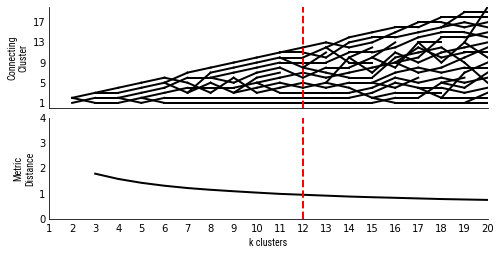

In [6]:




fig = plt.figure(figsize=(7,3.5))

ax1 = fig.add_axes([0.10,0.58,0.87,0.40])
ax2 = fig.add_axes([0.10,0.14,0.87,0.40])

######################################
# combine the methods into one figure

for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = hp.compute_cluster(all_year_data,years,nclusters1,min_pas=150,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:6]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = hp.compute_cluster(all_year_data,years,nclusters2,min_pas=150,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:6]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        ax1.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='black',lw=2.)
     
    

ax1.plot([12,12],[0,20],color='red',linestyle='dashed')


ax1.axis([1,20,0,20])


ax1.set_xticks(np.arange(1,21,1))
ax1.set_yticks(np.arange(1,21,4))

################################

ax2.plot(nclusters,distances/np.nanmean(distances),color='black')

ax2.plot([12,12],[0,4],color='red',linestyle='dashed')


#ax2.plot(nclusters[second_derivs.index(last_deriv)],distances[second_derivs.index(last_deriv)]/np.nanmean(distances), marker='o', color='r')

ax2.axis([1,20,0,4])
######################################



ax1.set_xticklabels(())
ax1.set_ylabel('Connecting\nCluster',size=12, fontproperties=prop)
ax2.set_ylabel('Metric\nDistance',size=12, fontproperties=prop)
ax2.set_xlabel('k clusters',size=12, fontproperties=prop)

ax2.set_xticks(np.arange(1,21,1))


for ax in [ax1,ax2]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

plt.savefig('figures/alllinking_hitting.png',dpi=400)


## Pitching

In [7]:

# which years are we interested in querying?
years = range(2019-3, 2019+1)


year_dfs = []

for year in years:
    print(year)

    df = pp.scrape_year(year=year,cat='pit',verbose=0)
    year_dfs.append(df)

# concatenate results from all years
all_year_data_pitching = year_dfs[0]
for year in year_dfs[1:]:
    all_year_data_pitching = pd.concat([all_year_data_pitching, year])
    





2016
2017
2018
2019


Text(0, 0.5, 'k Level')

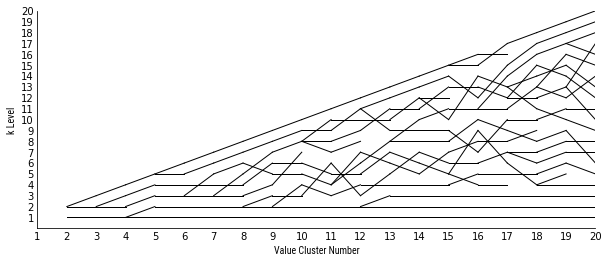

In [8]:

plt.figure(figsize=(10,4))

for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,nclusters1,min_ip=10,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:5]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,nclusters2,min_ip=10,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:5]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        plt.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='black',lw=1.)
     

plt.axis([1,20,0,20])

plt.xticks(np.arange(1,21,1))
plt.yticks(np.arange(1,21,1))
plt.xlabel('Value Cluster Number', fontproperties=prop)
plt.ylabel('k Level', fontproperties=prop)






Text(21.25, 0.5, 'Distance')

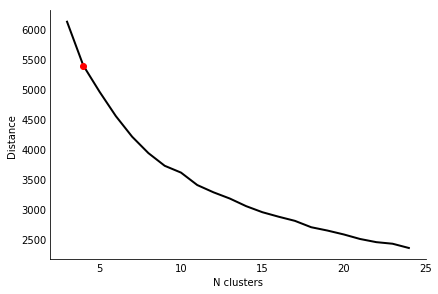

In [9]:

min_clusters = 3
nclusters_pitching = np.arange(min_clusters,25,1)#range(2,15)
distances_pitching = np.zeros(len(nclusters))

for indx,ccen in enumerate(nclusters):

    year_df,df,stereotype_df,hitter_cluster_centroid_df,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,ccen,min_ip=10,verbose=0)

    
    for p in transform:
        # why is this the minimum value?
        distances_pitching[indx] += np.sqrt(np.sum(p))#np.min(np.sqrt(p))
        
        #distances[indx] += np.sum(np.sqrt(p))

    distances_pitching[indx] /= float(ccen)
    #print(ccen,distances[indx])
     
        
# after doing the centering, compute the exponential decline
#print(curve_fit(lambda t,a,b,c: a*np.exp(b*t) + c,  ccen,  distances_pitching))

# Determine second derivs
second_derivs = []
for i in range(0, len(distances_pitching)-1):
    #print("Cluster {0}".format(i+3))
    cur_cluster_deriv =  round(distances_pitching[i+1]/distances_pitching[i], 2)
    #print(cur_cluster_deriv)
    second_derivs.append(cur_cluster_deriv)

# Find inflection point
last_deriv = second_derivs[0]
end = 0

for i in second_derivs[1:]:
    if end == 1:
        pass
    else:
        #print("Current Deriv: "+ str(i))
        #print("Last Deriv: "+ str(last_deriv))
        if i <= last_deriv:
            end = 1
        else:
            last_deriv = i

# Assign Total Clusters        
tot_clusters = min_clusters + second_derivs.index(last_deriv)

# Plot out the results
plt.figure()
plt.plot(nclusters_pitching,distances_pitching,color='black')
plt.plot(nclusters_pitching[second_derivs.index(last_deriv)],distances_pitching[second_derivs.index(last_deriv)], marker='o', color='r')
plt.tight_layout()
plt.xlabel('N clusters')
plt.ylabel('Distance')
#plt.savefig('cluster_number.png',dpi=300)



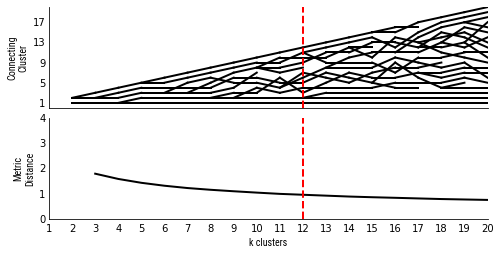

In [10]:




fig = plt.figure(figsize=(7,3.5))

ax1 = fig.add_axes([0.10,0.58,0.87,0.40])
ax2 = fig.add_axes([0.10,0.14,0.87,0.40])

######################################
# combine the methods into one figure

for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,nclusters1,min_ip=10,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:5]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,nclusters2,min_ip=10,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:5]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        ax1.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='black',lw=2.)
     



ax1.plot([12,12],[0,20],color='red',linestyle='dashed')


ax1.axis([1,20,0,20])


ax1.set_xticks(np.arange(1,21,1))
ax1.set_yticks(np.arange(1,21,4))

################################

ax2.plot(nclusters,distances/np.nanmean(distances),color='black')

ax2.plot([12,12],[0,4],color='red',linestyle='dashed')


#ax2.plot(nclusters[second_derivs.index(last_deriv)],distances[second_derivs.index(last_deriv)]/np.nanmean(distances), marker='o', color='r')

ax2.axis([1,20,0,4])
######################################



ax1.set_xticklabels(())
ax1.set_ylabel('Connecting\nCluster',size=12, fontproperties=prop)
ax2.set_ylabel('Metric\nDistance',size=12, fontproperties=prop)
ax2.set_xlabel('k clusters',size=12, fontproperties=prop)

ax2.set_xticks(np.arange(1,21,1))


for ax in [ax1,ax2]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

plt.savefig('figures/alllinking_pitching.png',dpi=400)



## Super COMBO Plot



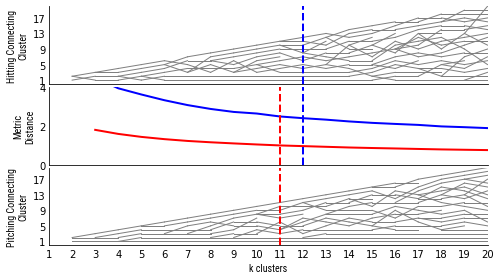

In [11]:


fig = plt.figure(figsize=(7,4))

ax1 = fig.add_axes([0.10,0.70,0.87,0.27])
ax2 = fig.add_axes([0.10,0.42,0.87,0.27])
ax3 = fig.add_axes([0.10,0.14,0.87,0.27])




######################################
# combine the methods into one figure

# hitting
for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = hp.compute_cluster(all_year_data,years,nclusters1,min_pas=150,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:6]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = hp.compute_cluster(all_year_data,years,nclusters2,min_pas=150,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:6]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        ax1.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='gray',lw=1.)
    
    
ax1.plot([12,12],[0,20],color='blue',linestyle='dashed')


    
# pitching
for n in range(2,20):
    nclusters1=n
    nclusters2=n+1
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df1,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,nclusters1,min_ip=10,verbose=0)
    arr1 = np.array(hitter_cluster_centroid_df1)[:,0:5]
    #
    year_df,df,stereotype_df,hitter_cluster_centroid_df2,transform = pp.compute_cluster_pitching(all_year_data_pitching,years,nclusters2,min_ip=10,verbose=0)
    arr2 = np.array(hitter_cluster_centroid_df2)[:,0:5]
    for i in range(0,nclusters2):
        minvals = np.argmin(np.sum(np.abs(arr2[i]-arr1),axis=1))
        ax3.plot([nclusters1,nclusters2],[nclusters1-minvals,nclusters2-i],color='gray',lw=1.)
     


ax3.plot([11,11],[0,20],color='red',linestyle='dashed')

    
for ax in [ax1,ax3]: 
    ax.axis([1,20,0,20])
    ax.set_xticks(np.arange(1,21,1))
    ax.set_yticks(np.arange(1,21,4))

################################

# shift the plots by a normalization factor
ax2.plot(nclusters,distances/np.nanmean(distances),color='red')
ax2.plot(nclusters_pitching,distances_pitching/np.nanmean(distances),color='blue')


ax2.plot([12,12],[0,4],color='blue',linestyle='dashed')
ax2.plot([11,11],[0,4],color='red',linestyle='dashed')

ax2.axis([1,20,0,4])


######################################



ax1.set_xticklabels(())
ax2.set_xticklabels(())

ax1.set_ylabel('Hitting Connecting\nCluster',size=12, fontproperties=prop)
ax3.set_ylabel('Pitching Connecting\nCluster',size=12, fontproperties=prop)
ax2.set_ylabel('Metric\nDistance',size=12, fontproperties=prop)
ax3.set_xlabel('k clusters',size=12, fontproperties=prop)

for ax in [ax1,ax2,ax3]:
    ax.set_xticks(np.arange(1,21,1))


for ax in [ax1,ax2]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)

plt.savefig('figures/alllinking.png',dpi=400)


